### Pembelajaran Mendalam Ganjil 2022 2023

Senin, 14 November 2022

# Latihan 5

### Convolutional Neural Network (Lanjutan 3)

Pada pertemuan kali ini, kita akan mencoba memanfaatkan CNN2D untuk melakukan prediksi lokasi suatu objek pada gambar.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load Data

1. `Melanggar-JPG.zip` yang berisi data-data gambar
2. `Melanggar-anotasi.xlsx` yaitu list koordinat di mana lokasi objek berada pada gambar

In [ ]:
# Unzip file

!unzip /content/drive/MyDrive/PELANGGAR-PARKIR/Melanggar-JPG.zip

Archive:  /content/drive/MyDrive/PELANGGAR-PARKIR/Melanggar-JPG.zip
  inflating: Melanggar-JPG/test-145.jpg  
  inflating: Melanggar-JPG/test-118.jpg  
  inflating: Melanggar-JPG/test-130.jpg  
  inflating: Melanggar-JPG/test-150.jpg  
  inflating: Melanggar-JPG/test-141.jpg  
  inflating: Melanggar-JPG/test-134.jpg  
  inflating: Melanggar-JPG/test-123.jpg  
  inflating: Melanggar-JPG/test-140.jpg  
  inflating: Melanggar-JPG/test-119.jpg  
  inflating: Melanggar-JPG/test-127.jpg  
  inflating: Melanggar-JPG/test-137.jpg  
  inflating: Melanggar-JPG/test-138.jpg  
  inflating: Melanggar-JPG/test-131.jpg  
  inflating: Melanggar-JPG/test-136.jpg  
  inflating: Melanggar-JPG/test-122.jpg  
  inflating: Melanggar-JPG/test-126.jpg  
  inflating: Melanggar-JPG/test-142.jpg  
  inflating: Melanggar-JPG/test-128.jpg  
  inflating: Melanggar-JPG/test-121.jpg  
  inflating: Melanggar-JPG/test-125.jpg  
  inflating: Melanggar-JPG/test-120.jpg  
  inflating: Melanggar-JPG/test-147.jpg  
  inflat

In [ ]:
# Kemudian kita load bagian list koordinatnya

import pandas as pd
ini = pd.read_excel('/content/drive/MyDrive/PELANGGAR-PARKIR/Melanggar-Anotasi.xlsx')
ini

,image_name,label_name,x1,y1,xwidth,yheight,image_width,image_height,x2,y2
0,test-01.jpg,rambu,356,4,227,231,862,863,583,235
1,test-01.jpg,mobil,161,718,478,145,862,863,639,863
2,test-01.jpg,mobil,661,783,134,80,862,863,795,863
3,test-02.jpg,mobil,183,178,140,106,360,360,323,284
4,test-02.jpg,rambu,11,33,147,265,360,360,158,298
...,...,...,...,...,...,...,...,...,...,...
263,test-146.jpg,rambu,64,27,42,52,177,177,106,79
264,test-147.jpg,rambu,1,12,95,114,274,274,96,126
265,test-148.jpg,rambu,68,92,81,82,246,246,149,174
266,test-149.jpg,rambu,27,1,192,158,371,371,219,159


In [ ]:
import pandas as pd

# Menentukan perbandingan ukuran baru dengan ukuran asli
width_ratio = 200 / ini['image_width']
height_ratio = 200 / ini['image_height']

# Mengubah nilai x1, y1, x2, dan y2 sesuai dengan perbandingan ukuran
ini["x1"] = ini["x1"] * width_ratio
ini["y1"] = ini["y1"] * height_ratio
ini["x2"] = ini["x2"] * width_ratio
ini["y2"] = ini["y2"] * height_ratio

# Menyimpan perubahan ke file anotasi
ini.to_csv("anotasi_rambu_resize200.csv", index=False)

In [ ]:
# Filter the rows where label_name is "rambu"
ini = ini[ini["label_name"] == "rambu"]
ini = ini.drop(columns=["label_name","xwidth","yheight","image_width", "image_height"])
ini

,image_name,x1,y1,x2,y2
0,test-01.jpg,82.598608,0.926999,135.266821,54.461182
4,test-02.jpg,6.111111,18.333333,87.777778,165.555556
5,test-03.jpg,11.038961,31.715210,59.090909,82.847896
12,test-04.jpg,0.000000,29.333333,44.816054,86.000000
13,test-05.jpg,6.444444,0.000000,98.222222,68.000000
...,...,...,...,...,...
263,test-146.jpg,72.316384,30.508475,119.774011,89.265537
264,test-147.jpg,0.729927,8.759124,70.072993,91.970803
265,test-148.jpg,55.284553,74.796748,121.138211,141.463415
266,test-149.jpg,14.555256,0.539084,118.059299,85.714286


In [ ]:
# Mengubah nilai x1, y1, x2, dan y2 menjadi integer
ini["x1"] = ini["x1"].round().astype(int)
ini["y1"] = ini["y1"].round().astype(int)
ini["x2"] = ini["x2"].round().astype(int)
ini["y2"] = ini["y2"].round().astype(int)

In [ ]:
ini

,image_name,x1,y1,x2,y2
0,test-01.jpg,83,1,135,54
4,test-02.jpg,6,18,88,166
5,test-03.jpg,11,32,59,83
12,test-04.jpg,0,29,45,86
13,test-05.jpg,6,0,98,68
...,...,...,...,...,...
263,test-146.jpg,72,31,120,89
264,test-147.jpg,1,9,70,92
265,test-148.jpg,55,75,121,141
266,test-149.jpg,15,1,118,86


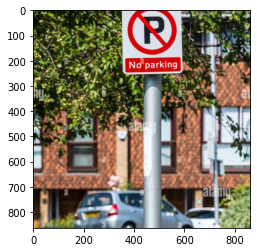

In [ ]:
import cv2
import matplotlib.pyplot as plt

lokasi = 0
gambar = cv2.imread("Melanggar-JPG/" + ini.values[lokasi,0])
gambar = cv2.cvtColor(gambar, cv2.COLOR_BGR2RGB)
plt.imshow(gambar)

Karena foto di folder Melanggar-JPG masih berisikan semua foto, disini membuat folder baru "melanggar_mobil" yang hanya terdapat gambar mobil berdasarkan dataset "ini" untuk data Training

In [ ]:
import os
import shutil
import pandas as pd

#Mencari nama file yang ada di dalam kolom "image_name"
files = ini["image_name"].tolist()

#Membuat folder baru, jika belum ada
if not os.path.exists("melanggar_rambu"):
    os.makedirs("melanggar_rambu")
#Memindahkan file yang ada di folder "Melanggar-jpg" ke folder baru, jika file tersebut ada di dalam kolom "image_name"
for file in os.listdir("Melanggar-JPG"):
    if file in files:
        os.rename("Melanggar-JPG/" + file, "melanggar_rambu/" + file)

In [ ]:
import cv2
import os

path = "melanggar_rambu"
for file in os.listdir(path):
    # Load gambar
    img = cv2.imread(os.path.join(path, file))
    # Resize gambar
    img = cv2.resize(img, (200, 200))
    # Save gambar yang sudah di resize
    cv2.imwrite(os.path.join(path, file), img)

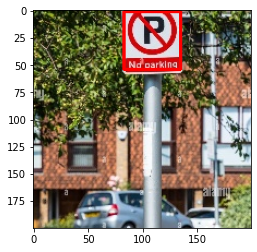

In [ ]:
# Sekarang, mari kita pergunakan fungsi cv2.
lokasi = 0
gambar = cv2.imread("melanggar_rambu/" + ini.values[lokasi,0])
gambar = cv2.cvtColor(gambar, cv2.COLOR_BGR2RGB)
gambar = cv2.rectangle(gambar, ini.values[lokasi,1:3], ini.values[lokasi,3:5], (255, 0, 0), 2)
plt.imshow(gambar)

## Otak CNN

Sekarang kita persiapkan otak CNN kita yang akan kita pergunakan untuk metrain agar dia dapat memprediksi di mana kira-kira lokasi koordinat objek tersebut berada.

Yang membedakan adalah `activation` pada `Dense` yang paling terakhir, di sana kita akan menggunakan `sigmoid` dengan jumlah `4 Dense` agar variabel `[x1, y1, x2, y2]` bisa diikutkan ditraining pada bagian output.

Satu lagi, karena ini merupakan kasus regresi, maka kita pastikan agar `loss` yang kita pergunakan adalah `mse`.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D

model = Sequential()
model.add(Conv2D(128, (3, 3), input_shape=(200, 200, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(8, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(4, activation='sigmoid'))
model.compile(optimizer='sgd', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 32)       0

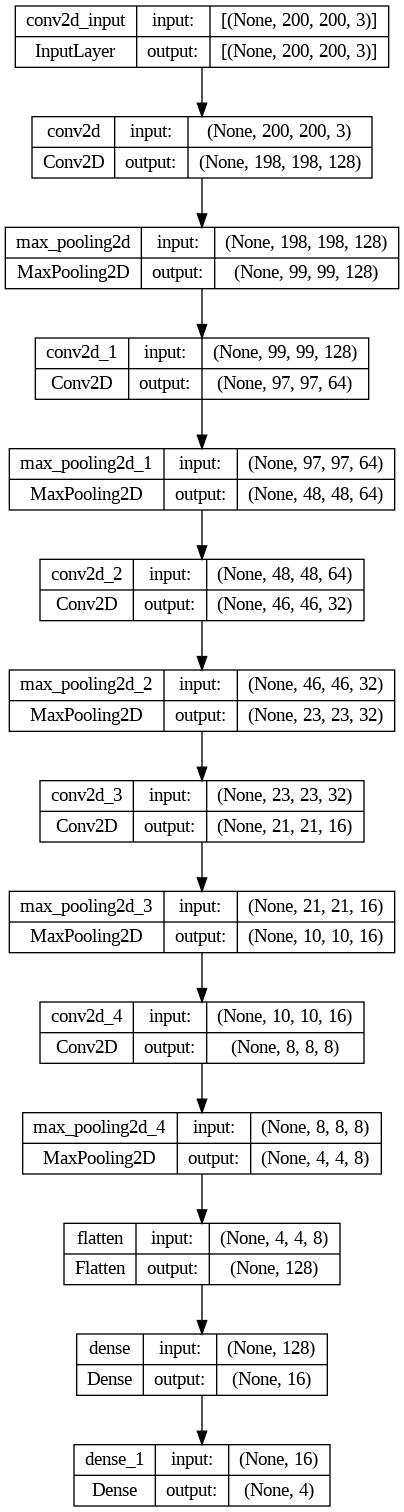

In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=True)

Selanjutnya kita persiapkan datasetnya, dengan cara sebagai berikut.

In [ ]:
import numpy as np
x = []
y = []

for info in ini.values:
    x.append(cv2.imread("melanggar_rambu/"+info[0])/255)
    y.append([info[1]/200, info[2]/200, info[3]/200, info[4]/200])

x = np.asarray(x)
y = np.asarray(y)

In [ ]:
x.shape

(121, 200, 200, 3)

In [ ]:
y.shape

(121, 4)

Baru kemudian kita train seperti biasa.

In [ ]:
history = model.fit(x, y, batch_size=1, epochs=50, validation_split=0.1)

Epoch 1/50
108/108 [==============================] - 23s 209ms/step - loss: 0.0863 - val_loss: 0.0707
Epoch 2/50
108/108 [==============================] - 24s 223ms/step - loss: 0.0813 - val_loss: 0.0671
Epoch 3/50
108/108 [==============================] - 22s 208ms/step - loss: 0.0778 - val_loss: 0.0629
Epoch 4/50
108/108 [==============================] - 25s 237ms/step - loss: 0.0732 - val_loss: 0.0580
Epoch 5/50
108/108 [==============================] - 22s 208ms/step - loss: 0.0684 - val_loss: 0.0526
Epoch 6/50
108/108 [==============================] - 22s 207ms/step - loss: 0.0624 - val_loss: 0.0448
Epoch 7/50
108/108 [==============================] - 22s 208ms/step - loss: 0.0543 - val_loss: 0.0364
Epoch 8/50
108/108 [==============================] - 23s 211ms/step - loss: 0.0483 - val_loss: 0.0327
Epoch 9/50
108/108 [==============================] - 23s 209ms/step - loss: 0.0460 - val_loss: 0.0319
Epoch 10/50
108/108 [==============================] - 22s 208ms/step - l

Setelah itu, mari kita coba test dengan memprediksi sebuah objek lingkaran pada file 10.jpg.

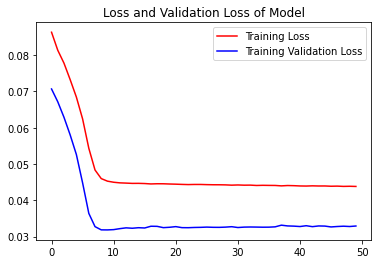

In [ ]:
%matplotlib inline
import matplotlib.image as mpig
import matplotlib.pyplot as plt

loss         = history.history['loss']
val_loss     = history.history['val_loss']

epochs = range(len(loss))
plt.plot(epochs, loss, 'r', label = "Training Loss")
plt.plot(epochs, val_loss, 'b', label = "Training Validation Loss")
plt.title("Loss and Validation Loss of Model")
plt.legend(loc = 'best')
plt.show()

In [ ]:
model.save_weights('Kipas_Angin_Fungsi_3_Rambu.h5')

In [ ]:
model.load_weights('/content/drive/MyDrive/PELANGGAR-PARKIR/Kipas_Angin_Fungsi_3_Rambu.h5')

In [ ]:
x_test = []
x_test.append(x[0])
#x_test.append(x[10])

x_test = np.asarray(x_test)
y_pred = model.predict(x_test)
y_pred = (y_pred)*200
y_pred = y_pred.astype(int)

y_pred

1/1 [==============================] - 0s 205ms/step


array([[ 71,  27, 118,  77]])

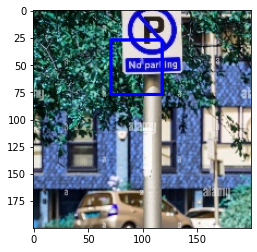

In [ ]:
gambar = x[0].copy()
gambar = cv2.rectangle(gambar, y_pred[0][0:2], y_pred[0][2:4],(0,0,255),2)
plt.imshow(gambar)

Tampak model kita sudah bisa melakukan deteksi walau masih belum terlalu presisi dalam menangkap objek lingkaran.